In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
home_path = '/home/robynm/simulations/Geometrical/'
sciama_path = '/mnt/lustre/munozr/runs/Geometrical/'
path = sciama_path
simname = 'BianchiII'

In [2]:
allNs = list(np.arange(8, 150, 8))
meanerror_4R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
for N in allNs:
    L = 20
    dx = L/N
    xyz = np.arange(-L/2, L/2, dx)[:N]
    xyz = xyz.astype('float128')
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])

    gamma = 1  #dust: 1, radiation: 4/3
    p1 = (2-gamma)/(2*gamma)
    p2 = (2+gamma)/(4*gamma)
    s = np.sqrt((2 - gamma)*(3*gamma-2))

    RRead.BASH('mkdir '+path+simname+'_N'+str(N))
    RRead.BASH('mkdir '+path+simname+'_N'+str(N)+'/all_iterations')    
    dtfac = 0.05
    dt = dx*dtfac
    t_array = np.arange(1.5-4*dt, 1.5+dt, dt)
    for it, t in enumerate(t_array):
        gdown = np.array([[(t**(2*p1))*Box_ones,      (t**(2*p1))*s*z/(2*gamma),                    Box_zero],
                          [(t**(2*p1))*s*z/(2*gamma), (t**(2*p2))+(t**(2*p1))*((s*z/(2*gamma))**2), Box_zero],
                          [Box_zero,                  Box_zero,                                     (t**(2*p2))*Box_ones]])

        Kdown = (-1/2)*np.array([[2*p1*(t**(2*p1-1))*Box_ones,      2*p1*(t**(2*p1-1))*s*z/(2*gamma),                           Box_zero],
                                 [2*p1*(t**(2*p1-1))*s*z/(2*gamma), 2*p2*(t**(2*p2-1))+2*p1*(t**(2*p1-1))*((s*z/(2*gamma))**2), Box_zero],
                                 [Box_zero,                         Box_zero,                                                   2*p2*(t**(2*p2-1))*Box_ones]])

        fname = path+simname+'_N'+str(N)+'/all_iterations/'+simname+'_it_{:06d}.hdf5'.format(it)
        with h5py.File(fname, 'w') as fnew:
            fnew['gxx it={}'.format(it)] = gdown[0,0]
            fnew['gxy it={}'.format(it)] = gdown[0,1]
            fnew['gxz it={}'.format(it)] = gdown[0,2]
            fnew['gyy it={}'.format(it)] = gdown[1,1]
            fnew['gyz it={}'.format(it)] = gdown[1,2]
            fnew['gzz it={}'.format(it)] = gdown[2,2]
            fnew['kxx it={}'.format(it)] = Kdown[0,0]
            fnew['kxy it={}'.format(it)] = Kdown[0,1]
            fnew['kxz it={}'.format(it)] = Kdown[0,2]
            fnew['kyy it={}'.format(it)] = Kdown[1,1]
            fnew['kyz it={}'.format(it)] = Kdown[1,2]
            fnew['kzz it={}'.format(it)] = Kdown[2,2]
            
    RRead.BASH("""printf "%s\n" "simname  = '"""+simname+"""'" "N = """+str(N)+"""" "L = """+str(L)+"""" "dtfac = """+str(dtfac)+"""" "boundary = False" "data_path = '"""+path+simname+'_N'+str(N)+"""/'"> data_analysis_codes/EBWeylparam.py""")
    RRead.BASH("python data_analysis_codes/EBWeyl_test.py")
    
    t = 1.5
    it = np.argmin(abs(t_array-t))
    fname = path+simname+'_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
    f = h5py.File(fname, 'r')
    
    gdetth = (t**(2*p1 + 4*p2))*Box_ones

    t1 = 2*(p1*p1 + p1*(-1 + 2*p2) + p2*(-2 + 3*p2))/(t*t)
    t2 = s*s*(t**(2*(p1-2*p2)))/(8*gamma*gamma)
    RicciS4th = Box_ones*(t1 - t2)
    if abs(np.mean(RicciS4th))>1e-15:
        meanerror_4R += [np.mean(np.ma.masked_invalid(abs(np.array(f['RicciS4'])/RicciS4th-1)))]
    else:
        meanerror_4R += [np.mean(np.ma.masked_invalid(abs(np.array(f['RicciS4']))))]

    B2th = 3*(p1 - p2)*(p1 - p2)*s*s*abs(gdetth)*(t**(-2 - 8*p2))/(8*gamma*gamma)
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['B2'])/B2th - 1)))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(np.array(f['Btrace']))))]

    parenthesis = (s**2)*(t**(2+2*p1)) - 4*gamma*gamma*(-1 + p1)*(p1 - p2)*(t**(4*p2))
    E2th = Box_ones*(t**(-4-8*p2))*(parenthesis**2)/(96*(gamma**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['E2'])/E2th - 1)))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(np.array(f['Etrace']))))]
    print('N={}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, meanerror_4R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))
    RRead.BASH('rm -rf '+path+simname+'_N'+str(N))

N=8, error=1.55e-04, 7.45e-16, 1.11e-19, 7.73e-04, 1.27e-19
N=16, error=6.62e-06, 7.33e-16, 9.85e-20, 3.31e-05, 1.42e-19
N=24, error=1.16e-06, 7.35e-15, 1.54e-19, 5.82e-06, 9.92e-20
N=32, error=3.48e-07, 7.31e-16, 1.13e-19, 1.74e-06, 1.04e-19
N=40, error=1.38e-07, 1.65e-14, 8.78e-20, 6.91e-07, 1.11e-19
N=48, error=6.52e-08, 1.20e-14, 1.48e-19, 3.26e-07, 1.11e-19
N=56, error=3.46e-08, 1.79e-14, 1.57e-19, 1.73e-07, 1.31e-19
N=64, error=2.01e-08, 7.36e-16, 1.05e-19, 1.00e-07, 1.30e-19
N=72, error=1.24e-08, 2.03e-14, 1.12e-19, 6.21e-08, 1.44e-19
N=80, error=8.09e-09, 1.53e-14, 1.18e-19, 4.05e-08, 1.37e-19
N=88, error=5.49e-09, 4.24e-14, 1.42e-19, 2.75e-08, 1.28e-19
N=96, error=3.86e-09, 2.45e-14, 1.14e-19, 1.93e-08, 1.45e-19
N=104, error=2.79e-09, 1.09e-14, 1.13e-19, 1.40e-08, 1.44e-19
N=112, error=2.07e-09, 1.88e-14, 1.31e-19, 1.03e-08, 1.29e-19
N=120, error=1.56e-09, 1.03e-14, 1.36e-19, 7.82e-09, 1.41e-19
N=128, error=1.21e-09, 7.33e-16, 1.23e-19, 6.03e-09, 1.35e-19
N=136, error=9.44e-10

<IPython.core.display.Javascript object>


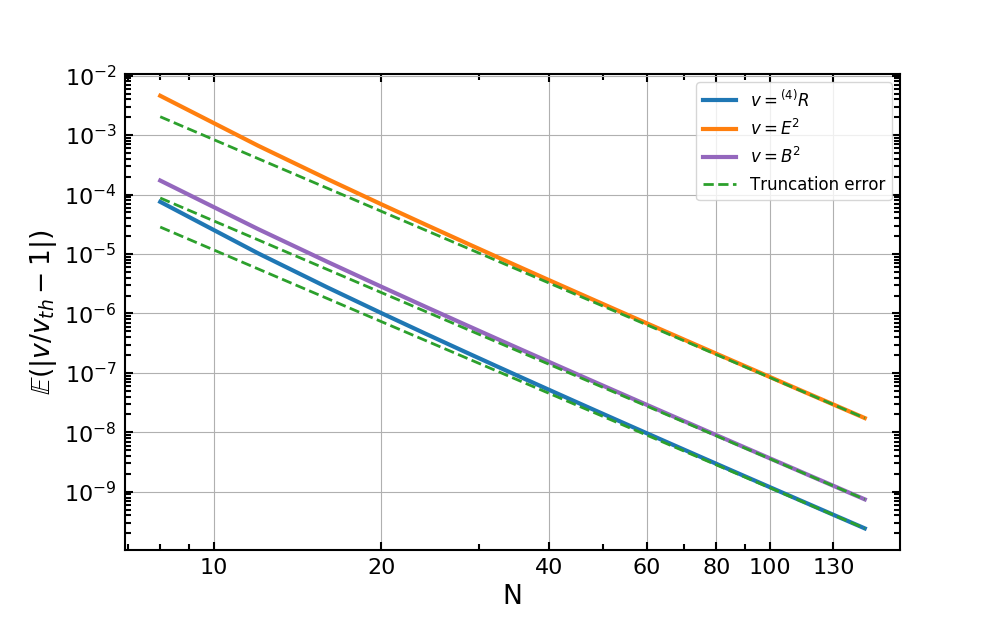

In [6]:
idec = -1
iinc = -1

phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.loglog(allNs, meanerror_4R, label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error')

plt.legend(loc=1, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.xticks([10,20,40,60,80,100,130], ['10','20','40','60','80','100','130'])
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
plt.savefig('Plots/BianchiII_Geometric_gamma=4d3.pdf')

In [3]:
import pandas as pd
data = np.array([allNs, meanerror_4R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '4R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/BianchiII_Geometric_gamma=1_128bit.csv')